In [1]:
# GOAL: 
# To build a model/classifier that accepts a chest x-ray image as input 
# and detects if a person has tuberculosis or not

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [4]:
# set directory
IMAGES_DIR = './images/'
MODEL_DIR = './model/best_model.h5'

# number of images
n_images = len(os.listdir(IMAGES_DIR))
'Number of images: {}'.format(n_images)

'Number of images: 800'

In [5]:
# get image files
images = glob.glob(IMAGES_DIR + '*.png')
images = [os.path.basename(img) for img in images]

# set up DataFrame
df = pd.DataFrame(images, columns=['filename'])

# extract labels from image filenames
df['label'] = df['filename'].map(
    lambda f: 'Tuberculosis' if int(os.path.splitext(f)[0][-1]) == 1 else 'Normal'
)

df.shape
df.head(5)

(800, 2)

,filename,label
0,CHNCXR_0078_0.png,Normal
1,CHNCXR_0532_1.png,Tuberculosis
2,CHNCXR_0503_1.png,Tuberculosis
3,CHNCXR_0614_1.png,Tuberculosis
4,CHNCXR_0289_0.png,Normal


In [6]:
# is the dataset imbalanced? Answer: Not really
df['label'].value_counts()

Normal          406
Tuberculosis    394
Name: label, dtype: int64

Text(0.5, 1.0, 'Tuberculosis')

Text(0.5, 1.0, 'Tuberculosis')

Text(0.5, 1.0, 'Tuberculosis')

Text(0.5, 1.0, 'Normal')

Text(0.5, 1.0, 'Normal')

Text(0.5, 1.0, 'Normal')

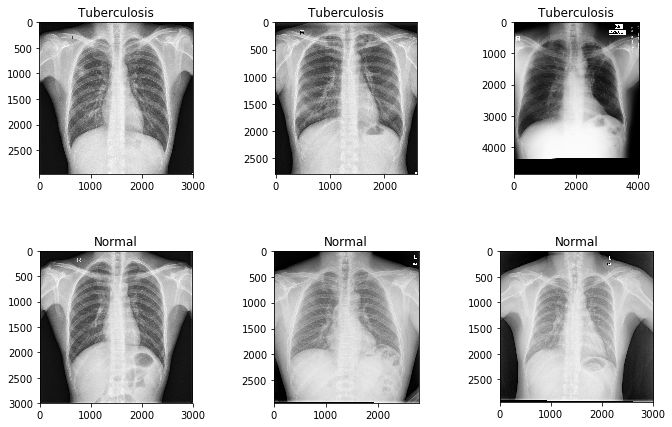

In [7]:
# display 3 samples from each class
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# get 3 samples from class 1
tb_images = df[df['label'] == 'Tuberculosis'].sample(3, random_state=25)

# get 3 samples from class 2
normal_images = df[df['label'] == 'Normal'].sample(3, random_state=25)

# merge
plot_images = (tb_images, normal_images)

# plot
for ii, c_ax in enumerate(axs):
    for jj, filename in enumerate(plot_images[ii]['filename']):
        img = mpimg.imread(IMAGES_DIR + filename)
        c_ax[jj].imshow(img, cmap='gray')
        
        label = plot_images[ii]['label'].iat[jj]
        c_ax[jj].set_title(label)

In [8]:
# prepare training and test sets

# shuffle dataset
df = df.sample(frac=1, random_state=28).reset_index(drop=True)

# divide dataset 90/10 with stratified sampling
X_train, X_test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=25)

# divide training set 75/25
X_train, X_valid = train_test_split(X_train, test_size=0.25, stratify=X_train['label'], random_state=25)

# reset indices
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train.shape
X_train.sample(3, random_state=25)

X_valid.shape
X_valid.sample(3, random_state=25)

X_test.shape
X_test.sample(3, random_state=25)

(540, 2)

,filename,label
6,CHNCXR_0301_0.png,Normal
275,CHNCXR_0431_1.png,Tuberculosis
517,CHNCXR_0587_1.png,Tuberculosis


(180, 2)

,filename,label
85,CHNCXR_0424_1.png,Tuberculosis
42,CHNCXR_0047_0.png,Normal
43,MCUCXR_0053_0.png,Normal


(80, 2)

,filename,label
54,CHNCXR_0647_1.png,Tuberculosis
13,CHNCXR_0624_1.png,Tuberculosis
53,CHNCXR_0094_0.png,Normal


In [9]:
# training set distribution
X_train['label'].value_counts()

Normal          274
Tuberculosis    266
Name: label, dtype: int64

In [10]:
# validation set distribution
X_valid['label'].value_counts()

Normal          91
Tuberculosis    89
Name: label, dtype: int64

In [11]:
# test set distribution
X_test['label'].value_counts()

Normal          41
Tuberculosis    39
Name: label, dtype: int64

In [12]:
# set up generators

# define batch size
BATCH_SIZE = 8

# define image resize dimensions
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

# define classes
classes = ['Normal', 'Tuberculosis']

datagen = ImageDataGenerator(rescale=1./255)

# init train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=IMAGES_DIR,
    x_col='filename',
    y_col='label',
    has_ext=True,
    batch_size=BATCH_SIZE,
    seed=25,
    classes=classes,
    color_mode='grayscale', # convert images to grayscale
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

# init validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=X_valid,
    directory=IMAGES_DIR,
    x_col='filename',
    y_col='label',
    has_ext=True,
    batch_size=BATCH_SIZE,
    seed=25,
    classes=classes,
    color_mode='grayscale', # convert images to grayscale
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=IMAGES_DIR,
    x_col='filename',
    y_col='label',
    has_ext=True,
    batch_size=BATCH_SIZE,
    seed=25,
    classes=classes,
    color_mode='grayscale', # convert images to grayscale
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False # do not shuffle test set
)

Found 540 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [13]:
# create the CNN architecture
def build_model():
    # 128 x 128 x 1
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)

    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2))) 
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3,3), activation ='relu'))
    model.add(Conv2D(64, (3,3), activation ='relu'))
    model.add(Conv2D(64, (3,3), activation ='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3,3), activation ='relu'))
    model.add(Conv2D(128, (3,3), activation ='relu'))
    model.add(Conv2D(128, (3,3), activation ='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation = 'softmax'))
    
    return model

In [14]:
# get model summary
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 64)        36928     
__________

In [15]:
# set up optimizer
optimizer = Adam(lr=0.0001)

# implement early stopping
es = EarlyStopping(patience=10)

# save best model so far
checkpoint = ModelCheckpoint(filepath=MODEL_DIR, save_best_only=True, save_weights_only=True)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
# number of images in training set
TRAIN_STEPS = train_generator.n // BATCH_SIZE
VALID_STEPS = valid_generator.n // BATCH_SIZE

'Training steps: {}'.format(TRAIN_STEPS)
'Validation steps: {}'.format(VALID_STEPS)

'Training steps: 67'

'Validation steps: 22'

In [17]:
# Start training!!!!!!!!!!!!
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=TRAIN_STEPS,
    validation_data=valid_generator,
    validation_steps=VALID_STEPS,
    callbacks=[es, checkpoint],
    epochs=80
)

Epoch 1/80
67/67 [==============================] - 59s 876ms/step - loss: 0.7009 - acc: 0.4962 - val_loss: 0.6931 - val_acc: 0.5909
Epoch 2/80
67/67 [==============================] - 58s 860ms/step - loss: 0.6922 - acc: 0.5074 - val_loss: 0.6929 - val_acc: 0.5057
Epoch 3/80
67/67 [==============================] - 58s 861ms/step - loss: 0.6928 - acc: 0.4982 - val_loss: 0.6921 - val_acc: 0.5568
Epoch 4/80
67/67 [==============================] - 57s 848ms/step - loss: 0.6889 - acc: 0.5728 - val_loss: 0.6895 - val_acc: 0.5227
Epoch 5/80
67/67 [==============================] - 57s 846ms/step - loss: 0.6405 - acc: 0.6455 - val_loss: 0.6931 - val_acc: 0.5057
Epoch 6/80
67/67 [==============================] - 55s 826ms/step - loss: 0.6036 - acc: 0.6865 - val_loss: 0.6519 - val_acc: 0.6648
Epoch 7/80
67/67 [==============================] - 55s 823ms/step - loss: 0.5714 - acc: 0.7183 - val_loss: 0.6514 - val_acc: 0.6989
Epoch 8/80
67/67 [==============================] - 55s 817ms/step - 

Text(0.5, 1.0, 'Training & validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training & validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Figure size 432x288 with 0 Axes>

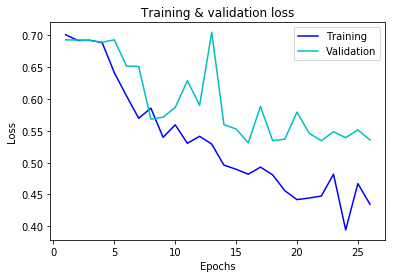

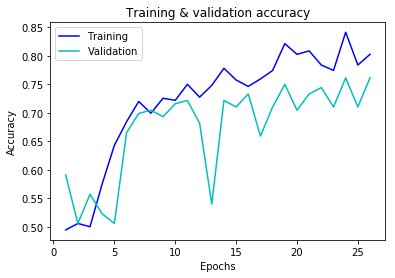

<Figure size 432x288 with 0 Axes>

In [18]:
# get training and validation loss
loss, acc = history.history['loss'], history.history['acc']

# get training and validation accuracy
val_loss, val_acc = history.history['val_loss'], history.history['val_acc']

# compute number of epochs
epochs = range(1, len(loss) + 1)

# plot training/validation loss
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'c', label='Validation')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

# plot training/validation accuracy
plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'c', label='Validation')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

In [19]:
# load model for prediction
model.load_weights(MODEL_DIR)

# evaluate test set
loss, acc = model.evaluate_generator(test_generator)

'Test set loss: {}'.format(loss)
'Test set Accuracy: {}'.format(acc)

'Test set loss: 0.5351355165243149'

'Test set Accuracy: 0.7625'

In [20]:
# predict test set
predictions = model.predict_generator(test_generator, verbose=1)

10/10 [==============================] - 7s 713ms/step


In [21]:
# get true labels
y = test_generator.classes

# get predicted labels
y_pred = predictions.argmax(axis=1)

# compute metrics
'Precision: {}'.format(precision_score(y, y_pred))
'Recall: {}'.format(recall_score(y, y_pred))

'Precision: 0.8571428571428571'

'Recall: 0.6153846153846154'

In [2]:
# plot confusion matrix
cm = confusion_matrix(y, y_pred)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={ "size": 20 })
ax.set_xticklabels(classes)
ax.set_yticklabels(classes, rotation_mode='anchor', ha='center')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

NameError: name 'confusion_matrix' is not defined

In [1]:
# compute metrics
tn, fp, fn, tp = cm.ravel()

'TN: {}'.format(tn)
'FP: {}'.format(fp)
'FN: {}'.format(fn)
'TP: {}'.format(tp)

'Sensitivity: {}'.format(tp / (tp + fn))
'Specificity: {}'.format(tn / (tn + fp))

NameError: name 'cm' is not defined